# Student information
Student: Balthazar Neveu

🔗 [Github](https://github.com/balthazarneveu/MVA24-delire) | [Online page for this class lab session](https://balthazarneveu.github.io/MVA24-delire)

⭐ [Online HTML version of this notebook](https://balthazarneveu.github.io/MVA24-delire/TP_5/tp_5.html)

# TP Coding a GAN in Pytorch

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore GANs applied to the mnist (and possibly cifar10) datasets.

We will start with the mnist dataset.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [33]:

import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image


def pytorch_to_numpy(x):
    return x.detach().numpy()


def sample_images(generator, z_dim, rand_seed=30):
    # np.random.seed(rand_seed)
    r, c = 5, 5
    z_random = torch.randn(r * c, 1, z_dim, dtype=torch.float, device=device)  # np.random.normal(0, 1, (r * c, z_dim))

    gen_imgs = np.transpose(generator(z_random).cpu().detach().numpy(), (0, 2, 3, 1))
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            # black and white images
            if (gen_imgs.shape[3] == 1):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            elif (gen_imgs.shape[3] == 3):  # colour images
                gen_imgs_temp = gen_imgs.copy()
                gen_imgs_temp = 255.*np.clip(gen_imgs_temp, 0.0, 1.0)
                axs[i, j].imshow(gen_imgs_temp[cnt, :, :, :].astype(np.uint8))
            else:
                print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## 1/ Loading the data

We define a function to load the mnist or cifar10 datasets. Note, we normalise the data between -1 and 1 here (this is often the case for GANs).

In [34]:

# create a random seed for reproducible results
random_seed = 1
torch.manual_seed(random_seed)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(
    mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0]
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(
    mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0]
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=64, shuffle=True)

In [35]:
N_ROWS = mnist_trainset_reduced.dataset.train_data.shape[1]
N_COLS = mnist_trainset_reduced.dataset.train_data.shape[2]
N_CHANNELS = 1
N_PIXELS = N_ROWS*N_COLS

img_shape = (N_ROWS, N_COLS, N_CHANNELS)

## 2/ GAN parameters

In [36]:

# GAN parameters
Z_DIM = 10
BATCH_SIZE = 64
# parameters for training
n_epochs = 400
n_iters_inner = 1  # number of internal loops
sample_interval = 100
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

# hidden dimensions : careful, the order here is with respect to the generator, and the discriminator is in the opposite order
H_DIM_1 = 256
H_DIM_2 = 512

## 3/ Model architecture

Now, we define the model architecture.

For the first dataset, mnist, we are going to use fully connected layers. Implement the following architecture, for the generator and the discriminator :

Generator :
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 784
- Tanh activation
- Reshape to size $28 \times 28 \times 1$

In [37]:
# Generator Code
class AdversarialElement(nn.Module):
    def __init__(
        self,
        z_dim: int = Z_DIM,
        h_dim_1: int = H_DIM_1,
        h_dim_2: int = H_DIM_2,
        n_rows: int = N_ROWS,
        n_cols: int = N_COLS,
        n_channels: int = N_CHANNELS
    ):
        super(AdversarialElement, self).__init__()
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_channels = n_channels
        self.n_pixels = (self.n_rows)*(self.n_cols)
        self.h_dim_1 = h_dim_1
        self.h_dim_2 = h_dim_2
        self.z_dim = z_dim
        self.n_pixels = (self.n_rows)*(self.n_cols)
        self.non_linear = torch.nn.LeakyReLU(negative_slope=0.2)
        # https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html

    def forward(self, x):
        raise NotImplementedError


class Generator(AdversarialElement):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.normalize_values = torch.nn.Tanh()
        self.fc1 = torch.nn.Linear(self.z_dim, self.h_dim_1)
        self.fc2 = torch.nn.Linear(self.h_dim_1, self.h_dim_2)
        self.fc3 = torch.nn.Linear(self.h_dim_2, self.n_pixels*self.n_channels)

        self.fwd = torch.nn.Sequential(
            self.fc1,
            self.non_linear,
            self.fc2,
            self.non_linear,
            self.fc3,
            self.normalize_values
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """Convert noise vector z into an image-like tensor.

        Args:
            z (torch.Tensor): [N, Z] Noise tensor of size (batch_size, z_dim)

        Returns:
            x (torch.Tensor): [N, C, H, W] Image tensor of size (batch_size, n_channels, n_rows, n_cols)
        """
        x = self.fwd(z)
        x = x.view(-1, self.n_channels, self.n_rows, self.n_cols)
        return x

Discriminator :
- Flatten
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 1
- Sigmoid activation

torch.Size([64])


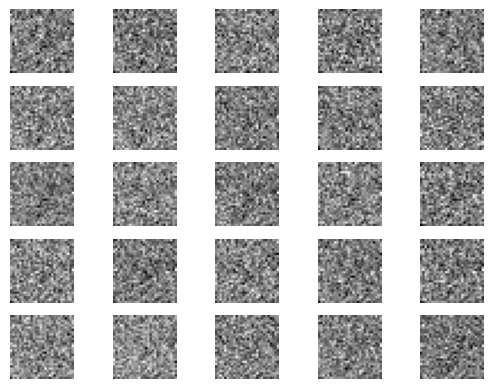

In [38]:
class Discriminator(AdversarialElement):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.fc1 = nn.Linear(self.n_pixels*self.n_channels, self.h_dim_2)
        self.fc2 = nn.Linear(self.h_dim_2, self.h_dim_1)
        self.fc3 = nn.Linear(self.h_dim_1, 1)
        self.normalize_values = torch.nn.Sigmoid()
        self.fwd = torch.nn.Sequential(
            self.fc1,
            self.non_linear,
            self.fc2,
            self.non_linear,
            self.fc3,
            self.normalize_values
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Discriminator forward function.

        Args:
            x (torch.Tensor): [N, C, H, W] Image tensor of size (batch_size, n_channels, n_rows, n_cols)

        Returns:
            torch.Tensor: probability of the image being real (after sigmoid)
        """
        y = x.view(-1, self.n_pixels*self.n_channels)
        y = self.fwd(y)
        assert (y<=1.).all() and (y>=0).all(), f"Output of the discriminator should be a probability\n{y}"
        y = y.squeeze(-1)
        return y

gen_test = Generator(n_channels=1).to(device)
out_gen = gen_test(torch.randn(BATCH_SIZE, gen_test.z_dim).to(device))
assert out_gen.shape == (
    BATCH_SIZE, gen_test.n_channels, gen_test.n_rows, gen_test.n_cols), "Wrong output size"

disc_test = Discriminator(n_channels=gen_test.n_channels).to(device)
proba_real = disc_test(out_gen)
print(proba_real.shape)
assert proba_real.shape == (BATCH_SIZE,), f"Wrong output size {proba_real.shape}"

sample_images(gen_test, gen_test.z_dim)
del gen_test, disc_test

Create generator and discriminator 

## 4/ Loss function


The GAN loss function is the following :
\begin{equation}
	\min_{G} \max_{D} \mathbb{E}_{x \in p_{data}} \left[ \log D(x)\right] +
	\mathbb{E}_{z \in p_{z}}\left[ \log \left( 1 - D(G(z)) \right)\right],
\end{equation}
where $G$ is the generator, $D$ is the discriminator, $z$ is the latent code, which follows a normal distribution.

You should notice that this is extremely similar to the binary cross-entropy function. Therefore, there is an intelligent way to train the discriminator : we give it first a batch of real images, and label them as real, and secondly we give a batch of fake images and label them as fake. Therefore, the discriminator training itself is done in two sequential steps (first true, then fake). If the labels are correctly chosen (further on, during training), you can (and __should__) use the binary cross-entropy function.

The generator loss, however, must be specified as :
- $mean(\log(1-D(G(z))))$

You can use the ```torch.mean``` function for this purpose.


The training is carried out sequentially : first we execute a few training steps on the discriminator, and then one on the generator. Therefore, we use two loops : one to train the discriminator (the internal loop) and one to train the generator (external loop, ie. the number of epochs). The GAN training algorithm is as follows :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$



### Sampling function

We now create a function to sample several images during training (to follow the convergence of the network)

## 5/ Training

We are now ready to train the network. Here is the training algorithm again :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$

You can use ```np.random.normal``` to create a batch of random latent codes, and ```np.random.randint``` to create a batch of random images.

You can then train the discriminator and the generator using the ```train_on_batch``` function.

We do not worry here about looping over the whole database : just create a random batch at each iteration.

In [40]:
# device = "cpu"

In [41]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Generator(
  (non_linear): LeakyReLU(negative_slope=0.2)
  (normalize_values): Tanh()
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
  (fwd): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)
Discriminator(
  (non_linear): LeakyReLU(negative_slope=0.2)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (normalize_values): Sigmoid()
  (fwd): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_featu

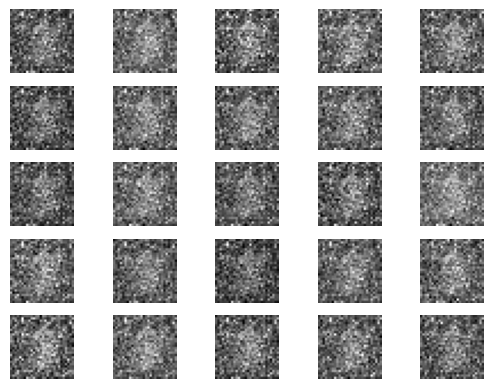

[1/400][0/16] 	Loss_D: 0.9754	Loss_G: -0.7555	D(x): 0.8742	D(G(z)): 0.5680
[2/400][0/16] 	Loss_D: 1.1745	Loss_G: -0.7339	D(x): 0.7505	D(G(z)): 0.5872
[3/400][0/16] 	Loss_D: 1.2230	Loss_G: -0.6817	D(x): 0.6779	D(G(z)): 0.5643
[4/400][0/16] 	Loss_D: 1.2532	Loss_G: -0.6420	D(x): 0.6463	D(G(z)): 0.5556
[5/400][0/16] 	Loss_D: 1.1650	Loss_G: -0.5368	D(x): 0.6001	D(G(z)): 0.4708
[6/400][0/16] 	Loss_D: 0.8172	Loss_G: -0.3404	D(x): 0.7423	D(G(z)): 0.4011
[7/400][0/16] 	Loss_D: 2.0924	Loss_G: -0.9660	D(x): 0.6285	D(G(z)): 0.7477
[8/400][0/16] 	Loss_D: 0.2877	Loss_G: -0.1345	D(x): 0.9121	D(G(z)): 0.1709
[9/400][0/16] 	Loss_D: 1.2858	Loss_G: -0.4027	D(x): 0.9039	D(G(z)): 0.4817
[10/400][0/16] 	Loss_D: 0.7105	Loss_G: -0.4637	D(x): 0.8208	D(G(z)): 0.3464
[11/400][0/16] 	Loss_D: 0.8982	Loss_G: -0.3630	D(x): 0.7204	D(G(z)): 0.4166
[12/400][0/16] 	Loss_D: 1.0766	Loss_G: -0.4135	D(x): 0.6535	D(G(z)): 0.4720
[13/400][0/16] 	Loss_D: 1.1066	Loss_G: -0.4926	D(x): 0.6072	D(G(z)): 0.4515
[14/400][0/16] 	Loss_

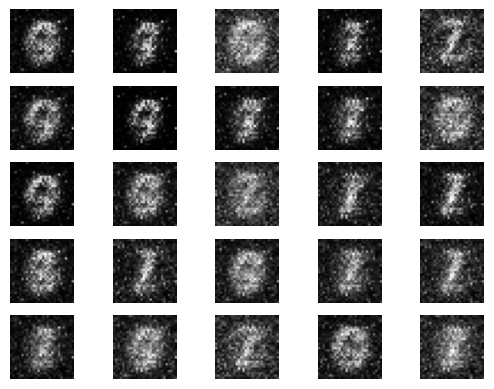

[26/400][0/16] 	Loss_D: 0.8972	Loss_G: -0.5965	D(x): 0.5515	D(G(z)): 0.1680
[27/400][0/16] 	Loss_D: 0.9350	Loss_G: -0.5110	D(x): 0.6471	D(G(z)): 0.3439
[28/400][0/16] 	Loss_D: 1.0887	Loss_G: -0.1854	D(x): 0.8499	D(G(z)): 0.5784
[29/400][0/16] 	Loss_D: 1.0375	Loss_G: -0.5172	D(x): 0.5829	D(G(z)): 0.3520
[30/400][0/16] 	Loss_D: 1.0916	Loss_G: -0.4803	D(x): 0.4908	D(G(z)): 0.2446
[31/400][0/16] 	Loss_D: 0.8148	Loss_G: -0.3072	D(x): 0.7530	D(G(z)): 0.3816
[32/400][0/16] 	Loss_D: 0.9901	Loss_G: -0.3873	D(x): 0.5979	D(G(z)): 0.3253
[33/400][0/16] 	Loss_D: 0.6805	Loss_G: -0.2788	D(x): 0.6656	D(G(z)): 0.1896
[34/400][0/16] 	Loss_D: 0.8040	Loss_G: -0.4518	D(x): 0.6869	D(G(z)): 0.3177
[35/400][0/16] 	Loss_D: 0.4087	Loss_G: -0.1998	D(x): 0.8126	D(G(z)): 0.1701
[36/400][0/16] 	Loss_D: 1.0257	Loss_G: -0.1630	D(x): 0.8179	D(G(z)): 0.5264
[37/400][0/16] 	Loss_D: 0.4950	Loss_G: -0.3011	D(x): 0.7395	D(G(z)): 0.1513
[38/400][0/16] 	Loss_D: 1.1904	Loss_G: -0.2978	D(x): 0.6414	D(G(z)): 0.4616
[39/400][0/1

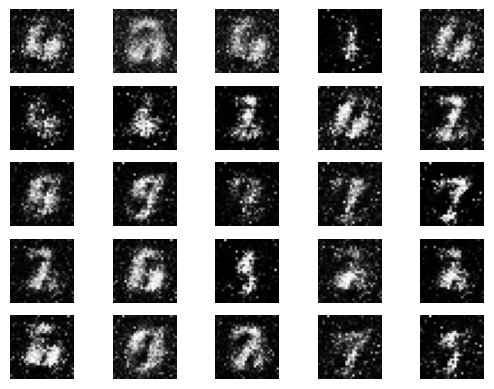

[51/400][0/16] 	Loss_D: 0.8473	Loss_G: -0.2705	D(x): 0.6514	D(G(z)): 0.3138
[52/400][0/16] 	Loss_D: 1.1732	Loss_G: -0.0941	D(x): 0.8819	D(G(z)): 0.6153
[53/400][0/16] 	Loss_D: 1.2712	Loss_G: -0.3111	D(x): 0.7810	D(G(z)): 0.6141
[54/400][0/16] 	Loss_D: 0.9458	Loss_G: -0.5848	D(x): 0.5165	D(G(z)): 0.1786
[55/400][0/16] 	Loss_D: 1.1482	Loss_G: -0.6455	D(x): 0.4509	D(G(z)): 0.1857
[56/400][0/16] 	Loss_D: 0.8604	Loss_G: -0.1373	D(x): 0.8045	D(G(z)): 0.4433
[57/400][0/16] 	Loss_D: 1.1860	Loss_G: -0.4963	D(x): 0.6079	D(G(z)): 0.4514
[58/400][0/16] 	Loss_D: 0.6886	Loss_G: -0.1660	D(x): 0.7931	D(G(z)): 0.3529
[59/400][0/16] 	Loss_D: 0.8579	Loss_G: -0.2534	D(x): 0.7232	D(G(z)): 0.3697
[60/400][0/16] 	Loss_D: 0.8972	Loss_G: -0.1727	D(x): 0.7659	D(G(z)): 0.4462
[61/400][0/16] 	Loss_D: 1.1365	Loss_G: -0.1525	D(x): 0.9112	D(G(z)): 0.6281
[62/400][0/16] 	Loss_D: 0.8223	Loss_G: -0.1428	D(x): 0.8086	D(G(z)): 0.4281
[63/400][0/16] 	Loss_D: 0.6014	Loss_G: -0.3721	D(x): 0.7129	D(G(z)): 0.1935
[64/400][0/1

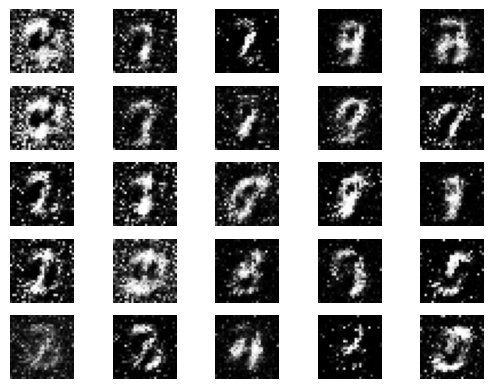

[76/400][0/16] 	Loss_D: 0.6601	Loss_G: -0.3834	D(x): 0.6289	D(G(z)): 0.0451
[77/400][0/16] 	Loss_D: 2.6702	Loss_G: -0.6529	D(x): 0.1593	D(G(z)): 0.0141
[78/400][0/16] 	Loss_D: 0.5738	Loss_G: -0.1420	D(x): 0.8388	D(G(z)): 0.3042
[79/400][0/16] 	Loss_D: 0.4397	Loss_G: -0.1714	D(x): 0.7919	D(G(z)): 0.1351
[80/400][0/16] 	Loss_D: 0.3912	Loss_G: -0.2210	D(x): 0.8143	D(G(z)): 0.1257
[81/400][0/16] 	Loss_D: 0.5542	Loss_G: -0.1061	D(x): 0.8547	D(G(z)): 0.2896
[82/400][0/16] 	Loss_D: 0.7840	Loss_G: -0.0241	D(x): 0.9540	D(G(z)): 0.4805
[83/400][0/16] 	Loss_D: 1.8078	Loss_G: -0.5888	D(x): 0.2733	D(G(z)): 0.0237
[84/400][0/16] 	Loss_D: 0.3295	Loss_G: -0.1833	D(x): 0.8617	D(G(z)): 0.1444
[85/400][0/16] 	Loss_D: 0.5538	Loss_G: -0.0956	D(x): 0.8821	D(G(z)): 0.3023
[86/400][0/16] 	Loss_D: 0.6702	Loss_G: -0.2478	D(x): 0.6582	D(G(z)): 0.0815
[87/400][0/16] 	Loss_D: 0.5494	Loss_G: -0.1618	D(x): 0.8491	D(G(z)): 0.2905
[88/400][0/16] 	Loss_D: 0.7815	Loss_G: -0.0248	D(x): 0.9517	D(G(z)): 0.4746
[89/400][0/1

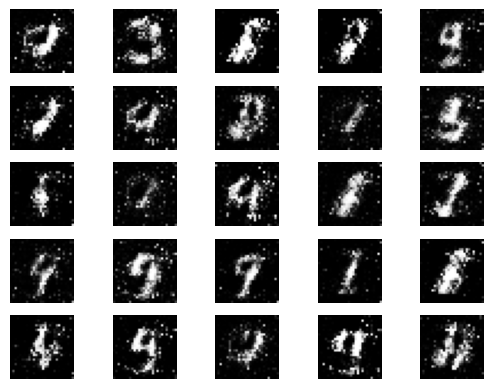

[101/400][0/16] 	Loss_D: 0.6023	Loss_G: -0.2006	D(x): 0.8350	D(G(z)): 0.3077
[102/400][0/16] 	Loss_D: 0.5577	Loss_G: -0.1862	D(x): 0.7799	D(G(z)): 0.2063
[103/400][0/16] 	Loss_D: 0.3669	Loss_G: -0.1451	D(x): 0.8333	D(G(z)): 0.1321
[104/400][0/16] 	Loss_D: 0.4311	Loss_G: -0.2168	D(x): 0.8608	D(G(z)): 0.2061
[105/400][0/16] 	Loss_D: 0.8029	Loss_G: -0.0486	D(x): 0.9268	D(G(z)): 0.4794
[106/400][0/16] 	Loss_D: 0.5904	Loss_G: -0.4124	D(x): 0.7370	D(G(z)): 0.1698
[107/400][0/16] 	Loss_D: 0.4936	Loss_G: -0.1128	D(x): 0.8417	D(G(z)): 0.1993
[108/400][0/16] 	Loss_D: 0.9285	Loss_G: -0.5541	D(x): 0.5267	D(G(z)): 0.0653
[109/400][0/16] 	Loss_D: 0.6692	Loss_G: -0.0452	D(x): 0.8823	D(G(z)): 0.3820
[110/400][0/16] 	Loss_D: 0.3354	Loss_G: -0.0809	D(x): 0.9267	D(G(z)): 0.1943
[111/400][0/16] 	Loss_D: 0.6433	Loss_G: -0.2173	D(x): 0.9127	D(G(z)): 0.3370
[112/400][0/16] 	Loss_D: 1.4328	Loss_G: -0.4977	D(x): 0.3969	D(G(z)): 0.0165
[113/400][0/16] 	Loss_D: 0.4897	Loss_G: -0.1917	D(x): 0.8080	D(G(z)): 0.1948

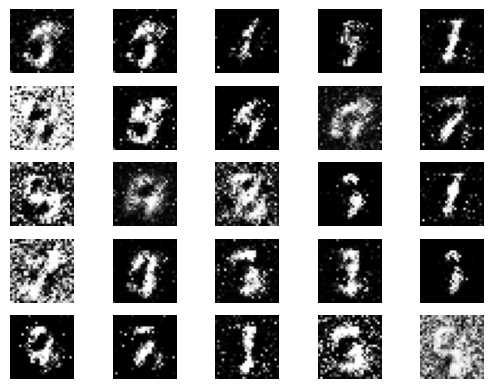

[126/400][0/16] 	Loss_D: 1.1876	Loss_G: -0.6304	D(x): 0.4998	D(G(z)): 0.0392
[127/400][0/16] 	Loss_D: 0.5866	Loss_G: -0.3057	D(x): 0.6884	D(G(z)): 0.0491
[128/400][0/16] 	Loss_D: 0.6298	Loss_G: -0.2449	D(x): 0.7215	D(G(z)): 0.1152
[129/400][0/16] 	Loss_D: 0.4697	Loss_G: -0.2681	D(x): 0.7955	D(G(z)): 0.1489
[130/400][0/16] 	Loss_D: 0.9908	Loss_G: -0.6040	D(x): 0.5044	D(G(z)): 0.0606
[131/400][0/16] 	Loss_D: 0.5077	Loss_G: -0.1436	D(x): 0.8121	D(G(z)): 0.2116
[132/400][0/16] 	Loss_D: 0.4199	Loss_G: -0.0947	D(x): 0.9481	D(G(z)): 0.2639
[133/400][0/16] 	Loss_D: 0.3474	Loss_G: -0.1245	D(x): 0.8353	D(G(z)): 0.1230
[134/400][0/16] 	Loss_D: 0.7598	Loss_G: -0.6647	D(x): 0.6242	D(G(z)): 0.0674
[135/400][0/16] 	Loss_D: 0.5618	Loss_G: -0.2577	D(x): 0.7565	D(G(z)): 0.1768
[136/400][0/16] 	Loss_D: 0.6280	Loss_G: -0.2212	D(x): 0.7356	D(G(z)): 0.1886
[137/400][0/16] 	Loss_D: 0.7093	Loss_G: -0.2571	D(x): 0.8905	D(G(z)): 0.3597
[138/400][0/16] 	Loss_D: 0.8047	Loss_G: -0.0433	D(x): 0.9080	D(G(z)): 0.4509

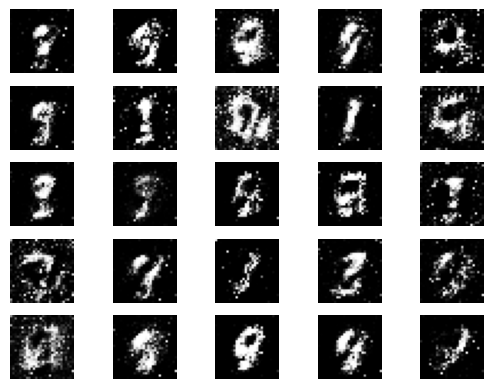

[151/400][0/16] 	Loss_D: 0.6864	Loss_G: -0.1007	D(x): 0.8994	D(G(z)): 0.3946
[152/400][0/16] 	Loss_D: 0.5698	Loss_G: -0.4314	D(x): 0.7096	D(G(z)): 0.1379
[153/400][0/16] 	Loss_D: 1.4559	Loss_G: -0.0495	D(x): 0.9624	D(G(z)): 0.6675
[154/400][0/16] 	Loss_D: 0.5746	Loss_G: -0.3578	D(x): 0.6695	D(G(z)): 0.0840
[155/400][0/16] 	Loss_D: 0.5096	Loss_G: -0.2443	D(x): 0.7880	D(G(z)): 0.1895
[156/400][0/16] 	Loss_D: 0.4498	Loss_G: -0.1642	D(x): 0.7891	D(G(z)): 0.1539
[157/400][0/16] 	Loss_D: 0.7346	Loss_G: -0.0394	D(x): 0.9450	D(G(z)): 0.4432
[158/400][0/16] 	Loss_D: 0.8083	Loss_G: -0.1158	D(x): 0.9239	D(G(z)): 0.4771
[159/400][0/16] 	Loss_D: 0.8685	Loss_G: -0.0190	D(x): 0.9333	D(G(z)): 0.4954
[160/400][0/16] 	Loss_D: 0.3836	Loss_G: -0.1699	D(x): 0.8570	D(G(z)): 0.1595
[161/400][0/16] 	Loss_D: 0.4730	Loss_G: -0.0374	D(x): 0.9455	D(G(z)): 0.3092
[162/400][0/16] 	Loss_D: 1.0233	Loss_G: -0.0109	D(x): 0.9730	D(G(z)): 0.5748
[163/400][0/16] 	Loss_D: 0.3633	Loss_G: -0.1490	D(x): 0.8422	D(G(z)): 0.1311

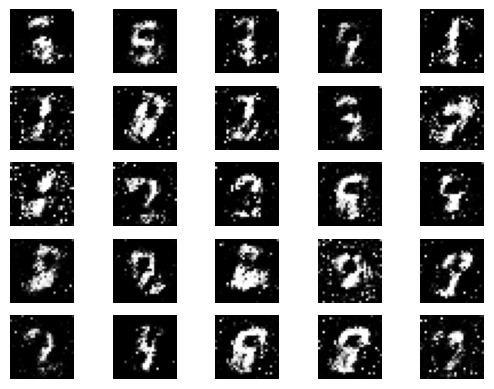

[176/400][0/16] 	Loss_D: 0.3196	Loss_G: -0.1708	D(x): 0.9120	D(G(z)): 0.1685
[177/400][0/16] 	Loss_D: 0.2128	Loss_G: -0.0928	D(x): 0.9124	D(G(z)): 0.0802
[178/400][0/16] 	Loss_D: 0.5262	Loss_G: -0.2147	D(x): 0.7628	D(G(z)): 0.0664
[179/400][0/16] 	Loss_D: 0.4665	Loss_G: -0.1829	D(x): 0.8244	D(G(z)): 0.1626
[180/400][0/16] 	Loss_D: 1.0502	Loss_G: -0.5263	D(x): 0.5016	D(G(z)): 0.0230
[181/400][0/16] 	Loss_D: 0.9027	Loss_G: -0.0048	D(x): 0.9773	D(G(z)): 0.4966
[182/400][0/16] 	Loss_D: 0.5606	Loss_G: -0.5424	D(x): 0.7081	D(G(z)): 0.0556
[183/400][0/16] 	Loss_D: 0.3793	Loss_G: -0.0464	D(x): 0.9254	D(G(z)): 0.2296
[184/400][0/16] 	Loss_D: 0.5276	Loss_G: -0.0172	D(x): 0.9582	D(G(z)): 0.3399
[185/400][0/16] 	Loss_D: 0.4185	Loss_G: -0.3644	D(x): 0.8064	D(G(z)): 0.1217
[186/400][0/16] 	Loss_D: 0.4965	Loss_G: -0.0521	D(x): 0.8996	D(G(z)): 0.2910
[187/400][0/16] 	Loss_D: 0.3074	Loss_G: -0.1891	D(x): 0.8457	D(G(z)): 0.0866
[188/400][0/16] 	Loss_D: 0.3843	Loss_G: -0.0755	D(x): 0.9312	D(G(z)): 0.2223

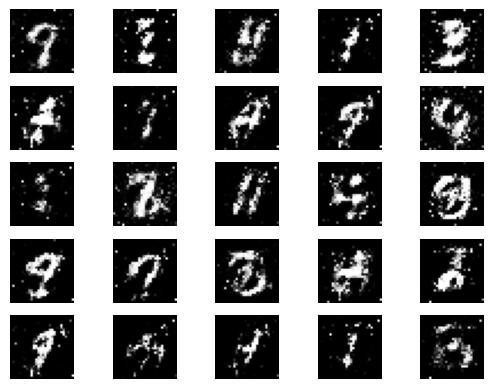

[201/400][0/16] 	Loss_D: 0.4144	Loss_G: -0.1778	D(x): 0.8281	D(G(z)): 0.1149
[202/400][0/16] 	Loss_D: 1.5506	Loss_G: -0.0205	D(x): 0.9597	D(G(z)): 0.6379
[203/400][0/16] 	Loss_D: 0.3166	Loss_G: -0.0682	D(x): 0.8407	D(G(z)): 0.0823
[204/400][0/16] 	Loss_D: 0.3248	Loss_G: -0.1425	D(x): 0.8641	D(G(z)): 0.1278
[205/400][0/16] 	Loss_D: 5.7243	Loss_G: -0.1456	D(x): 0.0374	D(G(z)): 0.0001
[206/400][0/16] 	Loss_D: 0.4792	Loss_G: -0.0889	D(x): 0.8725	D(G(z)): 0.2243
[207/400][0/16] 	Loss_D: 0.3503	Loss_G: -0.1748	D(x): 0.8439	D(G(z)): 0.1196
[208/400][0/16] 	Loss_D: 0.4665	Loss_G: -0.2282	D(x): 0.7924	D(G(z)): 0.1265
[209/400][0/16] 	Loss_D: 0.3229	Loss_G: -0.0819	D(x): 0.9634	D(G(z)): 0.2246
[210/400][0/16] 	Loss_D: 0.3163	Loss_G: -0.1513	D(x): 0.8585	D(G(z)): 0.0973
[211/400][0/16] 	Loss_D: 0.3600	Loss_G: -0.5491	D(x): 0.7988	D(G(z)): 0.0629
[212/400][0/16] 	Loss_D: 0.3849	Loss_G: -0.0973	D(x): 0.8486	D(G(z)): 0.1411
[213/400][0/16] 	Loss_D: 0.7858	Loss_G: -0.2923	D(x): 0.5903	D(G(z)): 0.0259

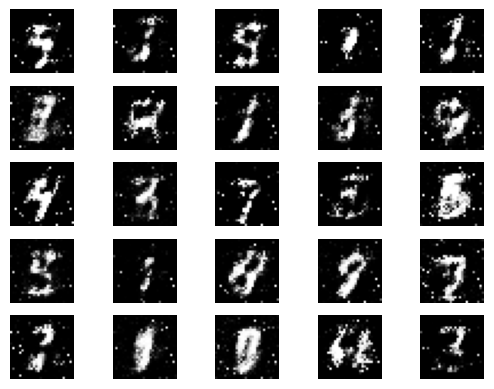

[226/400][0/16] 	Loss_D: 2.5267	Loss_G: -0.0011	D(x): 0.9962	D(G(z)): 0.8343
[227/400][0/16] 	Loss_D: 0.3618	Loss_G: -0.2439	D(x): 0.8336	D(G(z)): 0.1038
[228/400][0/16] 	Loss_D: 0.5000	Loss_G: -0.0418	D(x): 0.9439	D(G(z)): 0.3036
[229/400][0/16] 	Loss_D: 0.2435	Loss_G: -0.0758	D(x): 0.8886	D(G(z)): 0.0702
[230/400][0/16] 	Loss_D: 0.6014	Loss_G: -0.2757	D(x): 0.6860	D(G(z)): 0.0320
[231/400][0/16] 	Loss_D: 0.4371	Loss_G: -0.0721	D(x): 0.9031	D(G(z)): 0.2433
[232/400][0/16] 	Loss_D: 0.2608	Loss_G: -0.1076	D(x): 0.8973	D(G(z)): 0.1087
[233/400][0/16] 	Loss_D: 0.2942	Loss_G: -0.1157	D(x): 0.8771	D(G(z)): 0.0856
[234/400][0/16] 	Loss_D: 1.5666	Loss_G: -0.3062	D(x): 0.4254	D(G(z)): 0.0082
[235/400][0/16] 	Loss_D: 0.7468	Loss_G: -0.0160	D(x): 0.9685	D(G(z)): 0.4330
[236/400][0/16] 	Loss_D: 0.6539	Loss_G: -0.4390	D(x): 0.6578	D(G(z)): 0.0249
[237/400][0/16] 	Loss_D: 0.2116	Loss_G: -0.0614	D(x): 0.9326	D(G(z)): 0.1148
[238/400][0/16] 	Loss_D: 0.6647	Loss_G: -0.0074	D(x): 0.9765	D(G(z)): 0.3906

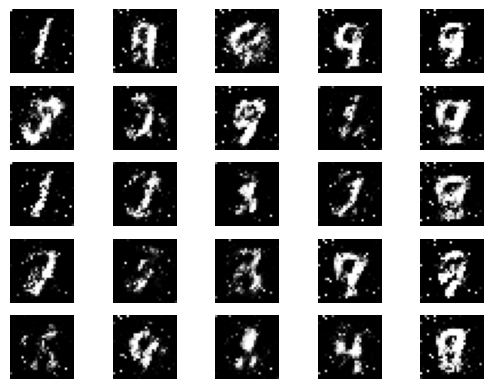

[251/400][0/16] 	Loss_D: 0.4839	Loss_G: -0.1833	D(x): 0.7084	D(G(z)): 0.0418
[252/400][0/16] 	Loss_D: 0.3711	Loss_G: -0.1400	D(x): 0.9143	D(G(z)): 0.2023
[253/400][0/16] 	Loss_D: 0.4607	Loss_G: -0.0639	D(x): 0.9338	D(G(z)): 0.2839
[254/400][0/16] 	Loss_D: 0.4359	Loss_G: -0.1889	D(x): 0.7397	D(G(z)): 0.0441
[255/400][0/16] 	Loss_D: 0.7869	Loss_G: -0.4048	D(x): 0.5941	D(G(z)): 0.0365
[256/400][0/16] 	Loss_D: 0.6101	Loss_G: -0.0277	D(x): 0.9180	D(G(z)): 0.3080
[257/400][0/16] 	Loss_D: 0.4542	Loss_G: -0.1549	D(x): 0.8540	D(G(z)): 0.1764
[258/400][0/16] 	Loss_D: 0.3647	Loss_G: -0.1355	D(x): 0.8639	D(G(z)): 0.1440
[259/400][0/16] 	Loss_D: 0.4162	Loss_G: -0.1260	D(x): 0.7622	D(G(z)): 0.0491
[260/400][0/16] 	Loss_D: 0.2793	Loss_G: -0.0371	D(x): 0.9452	D(G(z)): 0.1756
[261/400][0/16] 	Loss_D: 0.2599	Loss_G: -0.2232	D(x): 0.8935	D(G(z)): 0.1152
[262/400][0/16] 	Loss_D: 0.3355	Loss_G: -0.1649	D(x): 0.8503	D(G(z)): 0.1007
[263/400][0/16] 	Loss_D: 0.4745	Loss_G: -0.2478	D(x): 0.8275	D(G(z)): 0.1668

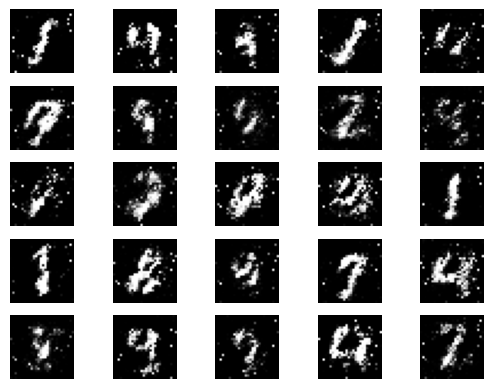

[276/400][0/16] 	Loss_D: 0.3830	Loss_G: -0.0719	D(x): 0.9794	D(G(z)): 0.2612
[277/400][0/16] 	Loss_D: 0.3423	Loss_G: -0.0442	D(x): 0.9069	D(G(z)): 0.1841
[278/400][0/16] 	Loss_D: 0.4024	Loss_G: -0.1249	D(x): 0.7868	D(G(z)): 0.0771
[279/400][0/16] 	Loss_D: 0.3257	Loss_G: -0.2663	D(x): 0.8235	D(G(z)): 0.0658
[280/400][0/16] 	Loss_D: 0.6542	Loss_G: -1.0913	D(x): 0.6482	D(G(z)): 0.0260
[281/400][0/16] 	Loss_D: 0.3609	Loss_G: -0.0901	D(x): 0.9246	D(G(z)): 0.2051
[282/400][0/16] 	Loss_D: 0.3009	Loss_G: -0.1400	D(x): 0.9297	D(G(z)): 0.1750
[283/400][0/16] 	Loss_D: 0.4638	Loss_G: -0.2857	D(x): 0.7567	D(G(z)): 0.0461
[284/400][0/16] 	Loss_D: 0.4379	Loss_G: -0.0552	D(x): 0.9053	D(G(z)): 0.2477
[285/400][0/16] 	Loss_D: 0.3623	Loss_G: -0.1188	D(x): 0.9121	D(G(z)): 0.1958
[286/400][0/16] 	Loss_D: 0.3605	Loss_G: -0.0834	D(x): 0.8872	D(G(z)): 0.1691
[287/400][0/16] 	Loss_D: 0.8186	Loss_G: -1.1666	D(x): 0.6051	D(G(z)): 0.0326
[288/400][0/16] 	Loss_D: 0.3672	Loss_G: -0.2271	D(x): 0.8388	D(G(z)): 0.1277

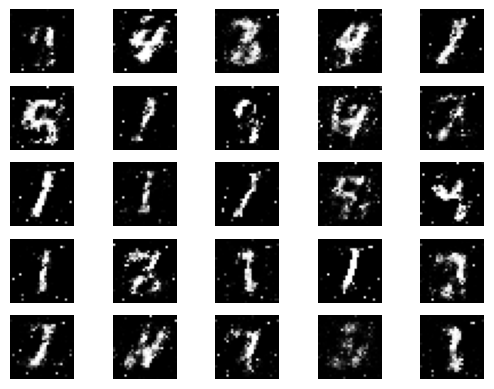

[301/400][0/16] 	Loss_D: 0.4055	Loss_G: -0.0749	D(x): 0.8540	D(G(z)): 0.1685
[302/400][0/16] 	Loss_D: 0.3574	Loss_G: -0.3104	D(x): 0.8453	D(G(z)): 0.1320
[303/400][0/16] 	Loss_D: 0.3080	Loss_G: -0.0916	D(x): 0.9356	D(G(z)): 0.1794
[304/400][0/16] 	Loss_D: 0.9555	Loss_G: -0.9567	D(x): 0.5527	D(G(z)): 0.0079
[305/400][0/16] 	Loss_D: 0.5257	Loss_G: -0.0288	D(x): 0.9299	D(G(z)): 0.3164
[306/400][0/16] 	Loss_D: 0.4995	Loss_G: -0.1496	D(x): 0.8276	D(G(z)): 0.2001
[307/400][0/16] 	Loss_D: 0.5386	Loss_G: -0.0480	D(x): 0.9138	D(G(z)): 0.3112
[308/400][0/16] 	Loss_D: 0.4164	Loss_G: -0.0995	D(x): 0.8844	D(G(z)): 0.2065
[309/400][0/16] 	Loss_D: 0.6380	Loss_G: -0.0668	D(x): 0.8975	D(G(z)): 0.3425
[310/400][0/16] 	Loss_D: 0.5782	Loss_G: -0.0533	D(x): 0.9549	D(G(z)): 0.3559
[311/400][0/16] 	Loss_D: 0.3883	Loss_G: -0.1823	D(x): 0.8143	D(G(z)): 0.0962
[312/400][0/16] 	Loss_D: 0.5112	Loss_G: -0.1371	D(x): 0.8604	D(G(z)): 0.2289
[313/400][0/16] 	Loss_D: 1.3584	Loss_G: -0.0282	D(x): 0.9901	D(G(z)): 0.6565

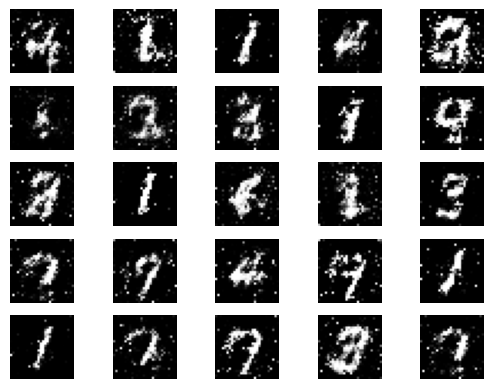

[326/400][0/16] 	Loss_D: 0.4709	Loss_G: -0.5193	D(x): 0.7713	D(G(z)): 0.1156
[327/400][0/16] 	Loss_D: 0.5438	Loss_G: -0.0345	D(x): 0.9363	D(G(z)): 0.3285
[328/400][0/16] 	Loss_D: 0.3211	Loss_G: -0.1613	D(x): 0.8660	D(G(z)): 0.1252
[329/400][0/16] 	Loss_D: 0.3509	Loss_G: -0.0635	D(x): 0.8787	D(G(z)): 0.1565
[330/400][0/16] 	Loss_D: 0.2913	Loss_G: -0.1107	D(x): 0.8539	D(G(z)): 0.0980
[331/400][0/16] 	Loss_D: 1.1078	Loss_G: -0.0373	D(x): 0.9722	D(G(z)): 0.5486
[332/400][0/16] 	Loss_D: 0.3472	Loss_G: -0.0978	D(x): 0.9301	D(G(z)): 0.2136
[333/400][0/16] 	Loss_D: 0.4312	Loss_G: -0.0751	D(x): 0.9459	D(G(z)): 0.2693
[334/400][0/16] 	Loss_D: 0.9009	Loss_G: -0.0086	D(x): 0.9806	D(G(z)): 0.5075
[335/400][0/16] 	Loss_D: 0.2968	Loss_G: -0.0878	D(x): 0.9182	D(G(z)): 0.1568
[336/400][0/16] 	Loss_D: 0.9457	Loss_G: -0.0207	D(x): 0.9729	D(G(z)): 0.5063
[337/400][0/16] 	Loss_D: 0.4697	Loss_G: -0.3597	D(x): 0.7494	D(G(z)): 0.0746
[338/400][0/16] 	Loss_D: 0.4143	Loss_G: -0.0977	D(x): 0.9269	D(G(z)): 0.2201

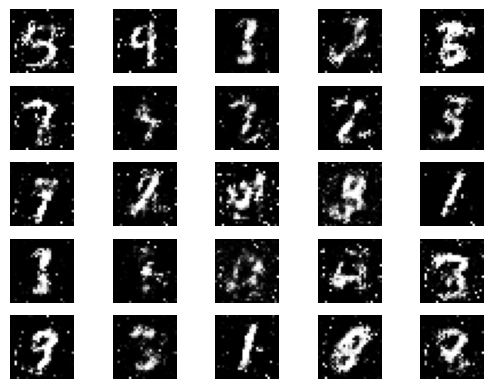

[351/400][0/16] 	Loss_D: 1.2590	Loss_G: -0.5851	D(x): 0.4977	D(G(z)): 0.0112
[352/400][0/16] 	Loss_D: 0.6590	Loss_G: -0.2846	D(x): 0.6808	D(G(z)): 0.0298
[353/400][0/16] 	Loss_D: 0.4710	Loss_G: -0.3370	D(x): 0.7528	D(G(z)): 0.0401
[354/400][0/16] 	Loss_D: 0.6539	Loss_G: -0.6187	D(x): 0.6554	D(G(z)): 0.0565
[355/400][0/16] 	Loss_D: 0.4645	Loss_G: -0.5597	D(x): 0.7998	D(G(z)): 0.1561
[356/400][0/16] 	Loss_D: 0.4682	Loss_G: -0.2068	D(x): 0.8258	D(G(z)): 0.1534
[357/400][0/16] 	Loss_D: 0.4907	Loss_G: -0.1568	D(x): 0.7447	D(G(z)): 0.0404
[358/400][0/16] 	Loss_D: 1.0018	Loss_G: -0.0197	D(x): 0.9572	D(G(z)): 0.5571
[359/400][0/16] 	Loss_D: 0.5003	Loss_G: -0.0827	D(x): 0.8956	D(G(z)): 0.2784
[360/400][0/16] 	Loss_D: 0.2587	Loss_G: -0.2256	D(x): 0.8852	D(G(z)): 0.1034
[361/400][0/16] 	Loss_D: 1.2999	Loss_G: -1.5554	D(x): 0.4428	D(G(z)): 0.0098
[362/400][0/16] 	Loss_D: 0.3193	Loss_G: -0.1669	D(x): 0.8335	D(G(z)): 0.0833
[363/400][0/16] 	Loss_D: 0.3409	Loss_G: -0.1761	D(x): 0.8292	D(G(z)): 0.0910

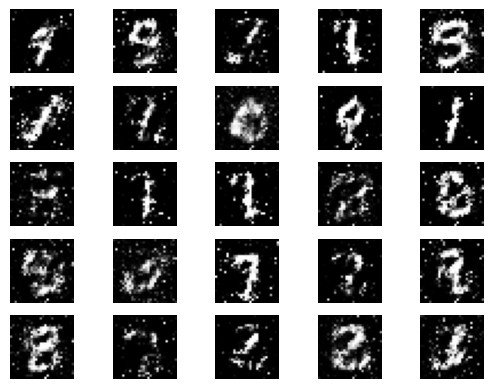

[376/400][0/16] 	Loss_D: 0.3943	Loss_G: -0.1874	D(x): 0.8255	D(G(z)): 0.1167
[377/400][0/16] 	Loss_D: 0.3589	Loss_G: -0.0513	D(x): 0.9175	D(G(z)): 0.1992
[378/400][0/16] 	Loss_D: 0.2936	Loss_G: -0.0521	D(x): 0.8441	D(G(z)): 0.0571
[379/400][0/16] 	Loss_D: 0.3883	Loss_G: -0.1475	D(x): 0.9166	D(G(z)): 0.2206
[380/400][0/16] 	Loss_D: 0.5482	Loss_G: -0.1497	D(x): 0.9661	D(G(z)): 0.3348
[381/400][0/16] 	Loss_D: 0.3239	Loss_G: -0.1852	D(x): 0.8295	D(G(z)): 0.0813
[382/400][0/16] 	Loss_D: 1.2837	Loss_G: -0.7942	D(x): 0.5041	D(G(z)): 0.0122
[383/400][0/16] 	Loss_D: 0.4057	Loss_G: -0.0473	D(x): 0.9185	D(G(z)): 0.2424
[384/400][0/16] 	Loss_D: 0.3809	Loss_G: -0.2611	D(x): 0.8366	D(G(z)): 0.0890
[385/400][0/16] 	Loss_D: 0.6821	Loss_G: -0.4287	D(x): 0.6514	D(G(z)): 0.0663
[386/400][0/16] 	Loss_D: 0.3993	Loss_G: -0.2975	D(x): 0.7767	D(G(z)): 0.0659
[387/400][0/16] 	Loss_D: 1.4044	Loss_G: -0.6700	D(x): 0.4111	D(G(z)): 0.0112
[388/400][0/16] 	Loss_D: 0.3758	Loss_G: -0.2395	D(x): 0.8183	D(G(z)): 0.0997

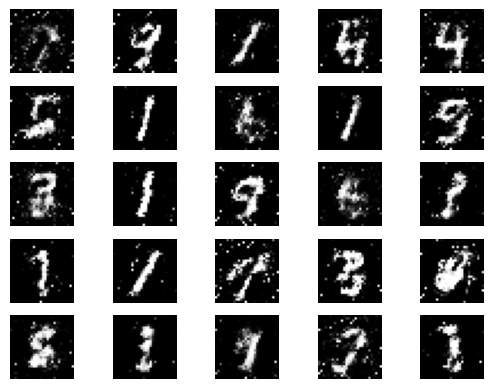

In [87]:
gen_model = Generator().to(device)
# Print the model
print(gen_model)

disc_model = Discriminator().to(device) # FILL IN HERE
# Print the model
print(disc_model)

gen_model = gen_model.to(device)
disc_model = disc_model.to(device)
# Setup Adam optimizers for both G and D
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))

# criterion used for the discriminator loss
bce_criterion = torch.nn.BCELoss()

# criterion used for the generator loss


def loss_fn_gen(d_gen_data: torch.Tensor) -> torch.Tensor:
    """
    log(1-D(G(z)))<0 Negative values that have to be maximized
    """
    loss_gen = torch.mean(torch.log(1-d_gen_data))   
    return loss_gen

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

sample_interval = 25
print("Starting Training")
# For each epoch
for epoch in range(n_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(mnist_train_loader, 0):
        for iter_inner in range(0, n_iters_inner):
            ############################
            # Train discriminator
            ############################
            # Train with true data batch
            disc_model.zero_grad()
            # create true data and labels
            true_imgs = data[0]
            true_imgs = true_imgs.to(device)  # FILL IN HERE
            true_labels = torch.ones(true_imgs.shape[0], device=device)  # FILL IN HERE
            # put true data through discriminator
            d_output_true = disc_model(true_imgs)  # FILL IN HERE
            # bce loss on true data
            d_loss_true = bce_criterion(d_output_true, true_labels)  # FILL IN HERE
            # backpropagation for discriminator, true loss
            d_loss_true.backward()
            disc_true_value = d_output_true.mean().item()

            if True:
                # Train with fake data batch
                # create fake data and labels
                # generate batch of random latent vectors
                z_latent_noise = torch.randn((true_imgs.shape[0], gen_model.z_dim), device=device)  # FILL IN HERE
                # Generate batch of fake images
                fake_imgs = gen_model(z_latent_noise)  # FILL IN HERE
                fake_labels = torch.zeros(true_imgs.shape[0], device=device)  # FILL IN HERE
                # put fake data through discriminator
                disc_output_fake = disc_model(fake_imgs)  # FILL IN HERE
                # bce loss on fake data
                disc_loss_fake = bce_criterion(disc_output_fake, fake_labels)  # FILL IN HERE
                # backpropagation for discriminator, fake loss
                disc_loss_fake.backward()
                disc_fake_value = disc_output_fake.mean().item()
                # Update discriminator
                optimizer_disc.step()

                d_loss_total = d_loss_true+disc_loss_fake

        ############################
        # Train generator
        ############################
        gen_model.zero_grad()
        # We have updated the discriminator, so we need to update the output of the discriminator
        z = torch.randn(BATCH_SIZE, Z_DIM, device=device)
        disc_gen_output_fake = disc_model(gen_model(z))  # FILL IN HERE
        # Generator loss, using the custom loss
        g_loss = loss_fn_gen(disc_gen_output_fake)  # FILL IN HERE
        # backpropagation for generator
        g_loss.backward()
        # D_G_z2 = output.mean().item()
        # Update generator
        optimizer_gen.step()

        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
                  % (epoch, n_epochs, i, len(mnist_train_loader), d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value))

        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss_total.item())

    if (epoch % sample_interval == 0):
        sample_images(gen_model, Z_DIM, rand_seed=30)

# end samples
sample_images(gen_model, Z_DIM, rand_seed=30)

## 6/ Navigating in the latent space

One of the main interests in the latent space is to be able to __navigate__ in it. For instance, one operation which is very common is to take two points $z_0$ and $z_1$ and to interpolate between the two. The images resulting from the generation of the interpolated points should ideally be a mix between the two initial points. 

The simplest method of interpolation is simply linear interpolation along the line connecting the two points. Obviously, this supposes that the latent space is linear in some sense, which may not be true, but we are going to take this approach here. 

First, find two inital points $z_0$ and $z_1$ which you feel represent two different digits well, and display their resulting generated images.  

In [92]:
gen_model = gen_model.eval().cpu()

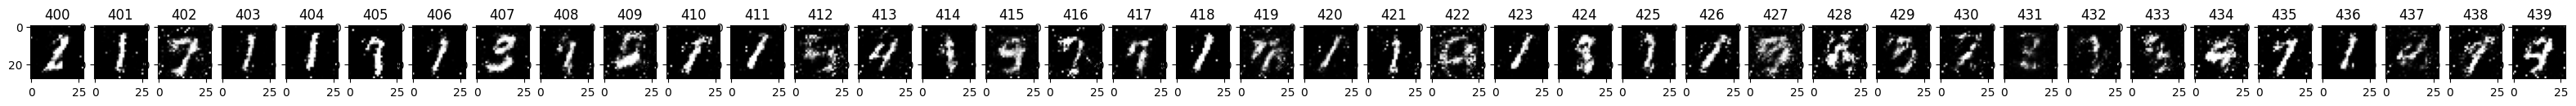

In [130]:
# first image

total = 40
plt.figure(figsize=(total, 1))
offset = 400
for idx, random_seed in enumerate(range(offset, offset+total)):
    torch.manual_seed(random_seed)
    z_0 =  torch.randn(1, Z_DIM)  # FILL IN HERE
    x_0 = gen_model(z_0)  # FILL IN HERE
    plt.subplot(1, total, idx+1)
    plt.title(f"{random_seed}")
    plt.imshow(x_0.detach().numpy().reshape(N_ROWS, N_COLS), cmap='gray')
plt.show()
# display images


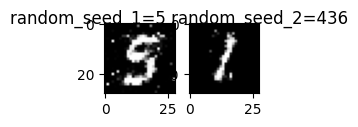

In [132]:
# first image
random_seed_1 = 5
torch.manual_seed(random_seed_1)
z_0 =  torch.randn(1, Z_DIM)  # FILL IN HERE
x_0 = gen_model(z_0)  # FILL IN HERE
random_seed_2 = 436
torch.manual_seed(random_seed_2)
z_1 = torch.randn(1, Z_DIM)  # FILL IN HERE
x_1 = gen_model(z_1)  # FILL IN HERE

plt.figure(figsize=(2, 1))
plt.subplot(1, 2, 1)
plt.imshow(x_0.detach().numpy().reshape(N_ROWS, N_COLS), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(x_1.detach().numpy().reshape(N_ROWS, N_COLS), cmap='gray')
plt.suptitle(f"{random_seed_1=:} {random_seed_2=:}")
plt.show()
# display images


Now, carry out the interpolation between these two points. You should __include__ the starting and ending codes $z_0$ and $z_1$. Display the results.

In [136]:
n_interpolation = 20
# for alpha in np.linspace(0, 1, n_interpolation):
alpha = torch.linspace(0, 1, n_interpolation).unsqueeze(-1)
z_interp = alpha*z_0.unsqueeze(0) + (1-alpha)*z_1.unsqueeze(0)
x_interp = gen_model(z_interp)


In [139]:
x_interp.shape

torch.Size([20, 1, 28, 28])

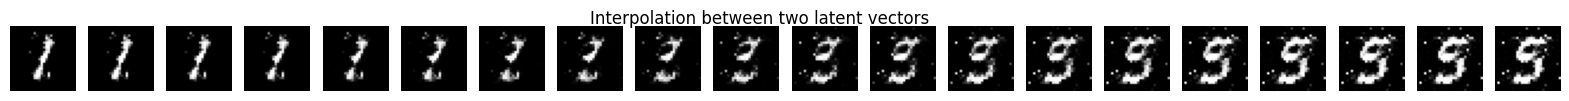

In [142]:
# display results

fig, axs = plt.subplots(1, n_interpolation, figsize=(20, 1))
for i in range(n_interpolation):
    # black and white images
    axs[i].imshow(x_interp[i, 0].detach().numpy(), cmap='gray')  # FILL IN HERE
    axs[i].axis('off')
plt.suptitle(f"Interpolation between two latent vectors")
plt.show()

What do you think of the quality of the output images ?

__Answer__

## 7/ Evaluation of navigation

Now, we are going to evaluate this navigation. We will investigate two properties:

- 1/ We are going to see whether by navigating between two points, the model produces images which are categorised in either of the classes (beginning class or end class), or if it traverses a region which is categorised in another class;
- 2/ We are going to see whether the confidence of a classification network in different regions varies much. In other words, when we navigate in the latent space, do we go into zones which do not correspond to any number (according to the classification network) ? 

For this, we will first need a classification network. Take the code from the last lab work on variational autoencoders, and extract the section where we trained a classifier on mnist. Here is the architecture we used:

- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- MaxPool2D, stride=(2,2)
- Flatten
- Dense layer

In [ ]:
# define mnist classifier model, loss function, optimiser and the function 'get_accuracy'

# FILL IN HERE

In [ ]:
# training the classifier

# FILL IN HERE

### 7.1/ Evaluation of navigation 1

Now, create a function which returns the classification returned by this network on mnist images. Remember, the classification model above returns the values __before__ the softmax is applied, and here we want the argmax, rather than the maximum probability. __Note__: the torch.max function returns a tuple: (max_values, max_indices).


In [ ]:
def predict_mnist_class(imgs_in, classification_model):
    output_classes = ...  # FILL IN HERE
    return (output_classes)

Carry out and print the classification of your interpolated latent space images. What are your remarks ? Does the latent space navigation traverse regions with classes other than those of $z_0$ and $z_1$ ?

In [ ]:
z_classes = ...  # FILL IN HERE
print(z_classes)

__Answer__

### 7.2/ Evaluation of navigation 2

Even though the network may predict coherent image classes during the navigation, it may predict these classes with different confidences. Ideally, we would like the latent space to contain codes which produce images of constant quality. Therefore, as mentioned above, we want to check these prediction confidences during navigation on our GAN.

Carry this out now. First of all, define a function which, instead of funding the output *classes* of the interpolations, find the *probability* of the most likely class (the same operation as in the lab on variational autoencoders).


In [ ]:
def predict_mnist_confidence(imgs_in, classification_model):
    output_classes = ...  # FILL IN HERE
    return (output_classes)

Using this function, carry out the second evaluation on the images generated by interpolated latent codes.

In [ ]:
z_confidence = ...  # FILL IN HERE
print(z_confidence)

Does the confidence change greatly during interpolation ? Does the navigation go through zones where the classification is not confident ? Why do you think this is ? (think about the form/shape of the latent space).

__Answer__

# __Optional__ : Training on CIFAR

If you want to try another, more challenging database, use the above code and modify it to carry out the GAN training on the CIFAR10 database. Note, it can take a long time to get good results

First, we download the data.

In [ ]:
# convert input to Pytorch tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# extract mnist data
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
print(cifar_trainset)

# create data loader with smaller dataset size
max_cifar_size = 2000
cifar_trainset_reduced = torch.utils.data.random_split(
    cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0]
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, BATCH_SIZE=64, shuffle=True)

# download test dataset
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, BATCH_SIZE=64, shuffle=True)

n_rows = 32
n_cols = 32
n_channels = 3
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

Now, we can redefine the hyper-parameters of the model (change if you wish)

In [ ]:
# GAN parameters
z_dim = 10
BATCH_SIZE = 64
n_epochs = 300
# parameters for training
n_iters_inner = 1  # number of internal loops
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

For this case of CIFAR, implement the following architecture :

- Generator :
  - Dense layer to size 1024
  - Leaky ReLU ($\alpha=0.2$)
  - Reshape, to size $4 \times 4 \times64$
  - % size = $4\times4\times64$
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $8\times 8\times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size=$16 \times 16 \times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=3,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $32 \times 32 \times 3$
  - Tanh activation ( you can use ```Activation('tanh')```)

- Discriminator :
  - % input size : $32 \times 32 \times 3$
  - Conv2D, 32 filters, kernel size = (3,3), strides = (1,1),padding = same
  - % size $32 \times 32 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - %size : $16 \times 16 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 64 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $8 \times 8 \times 64$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $4 \times 4 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Flatten
  - Dense layer to size 1
  - Sigmoid activation

  Implement this architecture below, and train the GAN. 

In [ ]:
# GAN implementation

# FILL IN HERE

Now, carry out the training (use code above)

In [ ]:
# training code

# FILL IN HERE